In [208]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb

In [209]:
import pandas
df = pd.read_csv('bike_buyers.csv')
print(df)

        ID Marital Status  Gender    Income  Children        Education  \
0    12496        Married  Female   40000.0       1.0        Bachelors   
1    24107        Married    Male   30000.0       3.0  Partial College   
2    14177        Married    Male   80000.0       5.0  Partial College   
3    24381         Single     NaN   70000.0       0.0        Bachelors   
4    25597         Single    Male   30000.0       0.0        Bachelors   
..     ...            ...     ...       ...       ...              ...   
995  23731        Married    Male   60000.0       2.0      High School   
996  28672         Single    Male   70000.0       4.0  Graduate Degree   
997  11809        Married     NaN   60000.0       2.0        Bachelors   
998  19664         Single    Male  100000.0       3.0        Bachelors   
999  12121         Single    Male   60000.0       3.0      High School   

         Occupation Home Owner  Cars Commute Distance         Region   Age  \
0    Skilled Manual        Yes   

# Visualisation des manquants

Nombre de données manquantes par colonne


ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

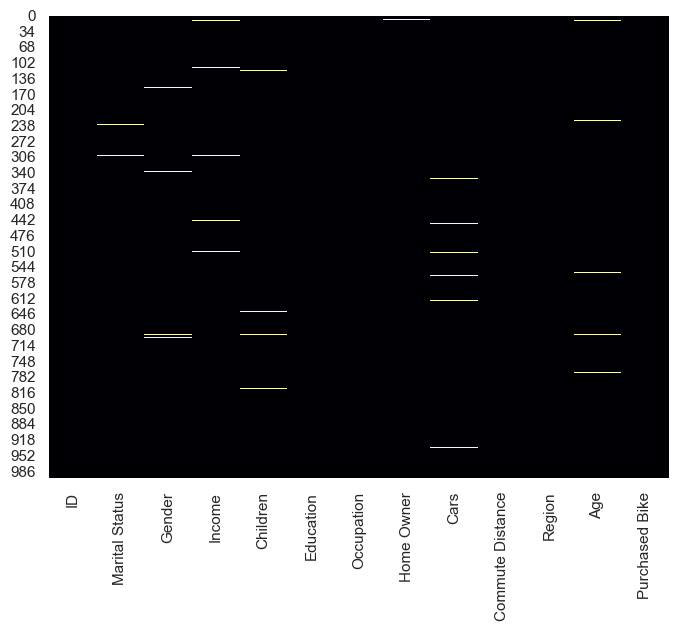

In [210]:
print("Nombre de données manquantes par colonne")
plt.figure(figsize = (8,6))
sb.heatmap(df.isnull(), cbar=False , cmap = 'magma')

df.isnull().sum()

In [211]:
print("Nombre de données dupliquées : " , df.duplicated().sum())


Nombre de données dupliquées :  0


## Cleaning

In [212]:
print(df.shape)
df_dropped = df.dropna(how = 'any')
print(df_dropped.shape)

(1000, 13)
(952, 13)


# Analyse des données

## Classification - clustering

In [213]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import seaborn as sns

sns.set()

In [217]:
def get_best_clustering(df):
    # On récupère les colonnes numériques
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = numeric_cols.drop('ID')
    
    # On récupère les colonnes catégorielles
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # On crée un objet ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ])
    
    # On applique le ColumnTransformer sur le DataFrame
    X = preprocessor.fit_transform(df)
    
    # On crée une liste pour stocker les inerties
    inertias = []
    
    # On crée une liste de valeurs de k
    k_range = range(1, 20)
    
    # Pour chaque valeur de k
    for k in k_range:
        # On instancie et on entraîne le modèle
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        
        # On stocke l'inertie
        inertias.append(kmeans.inertia_)
    
    # On affiche la courbe d'inertie
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, inertias, marker='o')
    plt.title("Courbe d'inertie")
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.xticks(k_range)
    plt.show()
    
    
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(X)
    labels = kmeans.labels_
    df["clusters"] = labels
    sns.pairplot(df, hue="clusters", palette="viridis")

get_best_clustering(df_dropped)

'\n# Pour chaque nombre de clusters : \nfor k in k_list : \n        kmeans = KMeans(n_clusters=k)\n        kmeans.fit(numeric_cols)\n        intertia_list.append(kmeans.inertia_)\n        \nfig, ax = plt.subplots(1,1,figsize=(12,6))\nax.set_ylabel("intertia")\nax.set_xlabel("n_cluster")\nax = plt.plot(k_list, intertia_list)\n'

On observe sur le graphique ci-dessus que la cassure de la courbe est à 2. On chosit donc de faire un clustering en 2 classes.

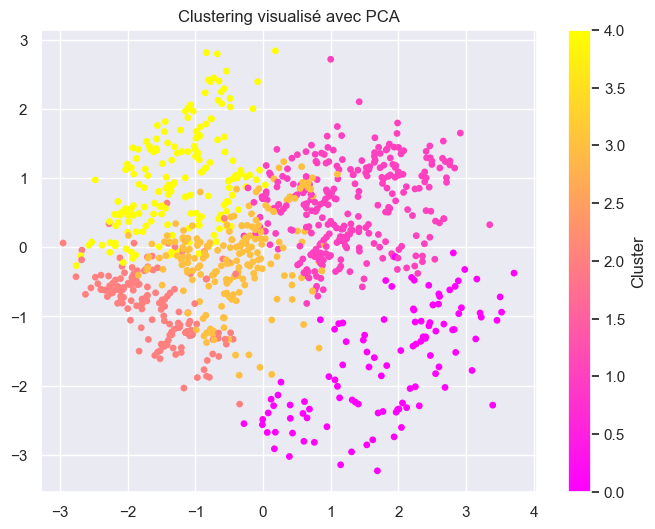

C:\Users\runhi\AppData\Local\Temp\ipykernel_21516\1988114819.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters



Proportion d'achats de vélo par cluster :
Purchased Bike        No       Yes
cluster                           
0               0.438462  0.561538
1               0.620370  0.379630


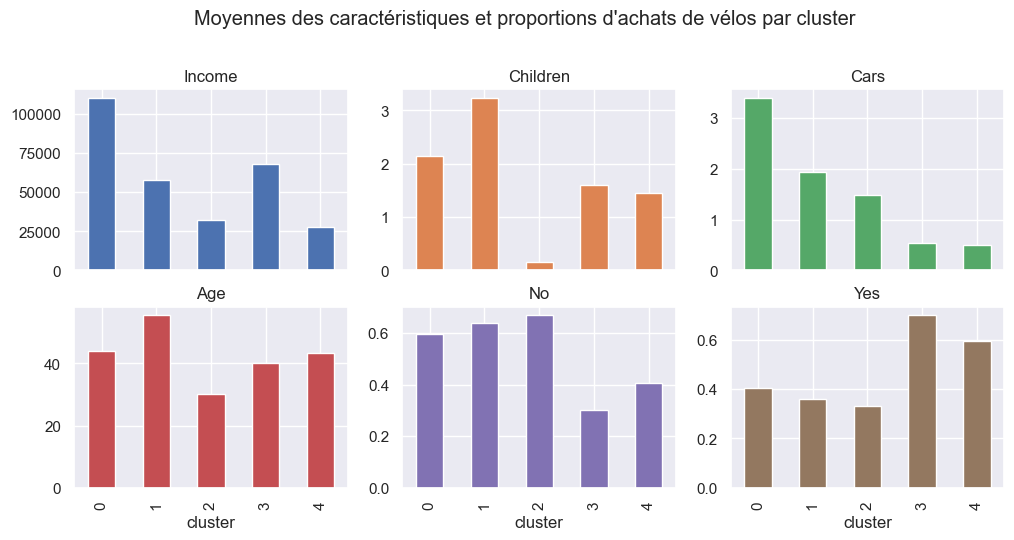

In [215]:
def clustering(df):
    cat_features = df.select_dtypes(include = ['object']).columns
    num_features = df.select_dtypes(include = ['float64', 'int64']).columns
    num_features = num_features.drop('ID')
 
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

    data_preprocessed = preprocessor.fit_transform(df)

    # Clustering avec KMeans
    kmeans = KMeans(n_clusters=5)
    clusters = kmeans.fit_predict(data_preprocessed)

    # Réduction de dimension avec PCA
    pca = PCA(n_components=20)
    reduced_data = pca.fit_transform(data_preprocessed)

    # Affichage des clusters en 2D
    plt.figure(figsize=(8,6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=15, c=clusters, cmap='spring')
    plt.title('Clustering visualisé avec PCA')
    plt.colorbar(label='Cluster')
    plt.show()
    
    # Ajouter les clusters au DataFrame original
    df['cluster'] = clusters
    
    # Calculer les moyennes seulement pour les colonnes numériques (sauf l'ID)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = numeric_cols.drop('ID') 
    cluster_means = df.groupby('cluster')[numeric_cols].mean()

    # Analyse de 'Purchased Bike' dans chaque cluster
    purchase_counts = df.groupby('cluster')['Purchased Bike'].value_counts(normalize=True).unstack()
    
    print("\nProportion d'achats de vélo par cluster :")
    print(purchase_counts)

    # Combiner les moyennes et les proportions d'achat de vélos dans un seul DataFrame
    summary_df = pd.concat([cluster_means, purchase_counts], axis=1)
    
    # Visualisation avec un graphique en barres pour chaque colonne
    summary_df.plot(kind='bar', figsize=(12,8), subplots=True, layout=(3, 3), sharex=True, legend=False)

    plt.suptitle('Moyennes des caractéristiques et proportions d\'achats de vélos par cluster')
    plt.show()
    
    
clustering(df_dropped)

              Income    Children        Cars         Age  Purchased Bike
count     994.000000  992.000000  991.000000  992.000000     1000.000000
mean    56267.605634    1.910282    1.455096   44.181452        0.481000
std     31067.817462    1.626910    1.121755   11.362007        0.499889
min     10000.000000    0.000000    0.000000   25.000000        0.000000
25%     30000.000000    0.000000    1.000000   35.000000        0.000000
50%     60000.000000    2.000000    1.000000   43.000000        0.000000
75%     70000.000000    3.000000    2.000000   52.000000        1.000000
max    170000.000000    5.000000    4.000000   89.000000        1.000000


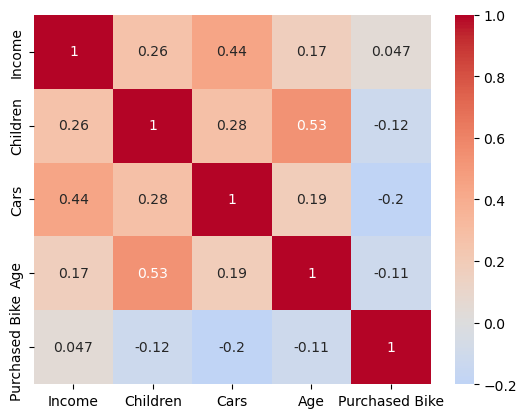

In [20]:

import seaborn as sns

df['Purchased Bike'] = df['Purchased Bike'].map({'Yes': 1, 'No': 0})

df_num = df.select_dtypes(include = ['float64', 'int64'])

df_without_ID = df_num.drop('ID', axis=1)

if 'Purchase Bike' in df_without_ID.columns:
    df_without_ID = df_without_ID.append(pd.Index(['Purchased Bike']))

print(df_without_ID.describe())
sns.heatmap(df_without_ID.corr(), annot=True, cmap='coolwarm', center=0)
plt.show()



       Purchased Bike
count     1000.000000
mean         0.481000
std          0.499889
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000


<Axes: >

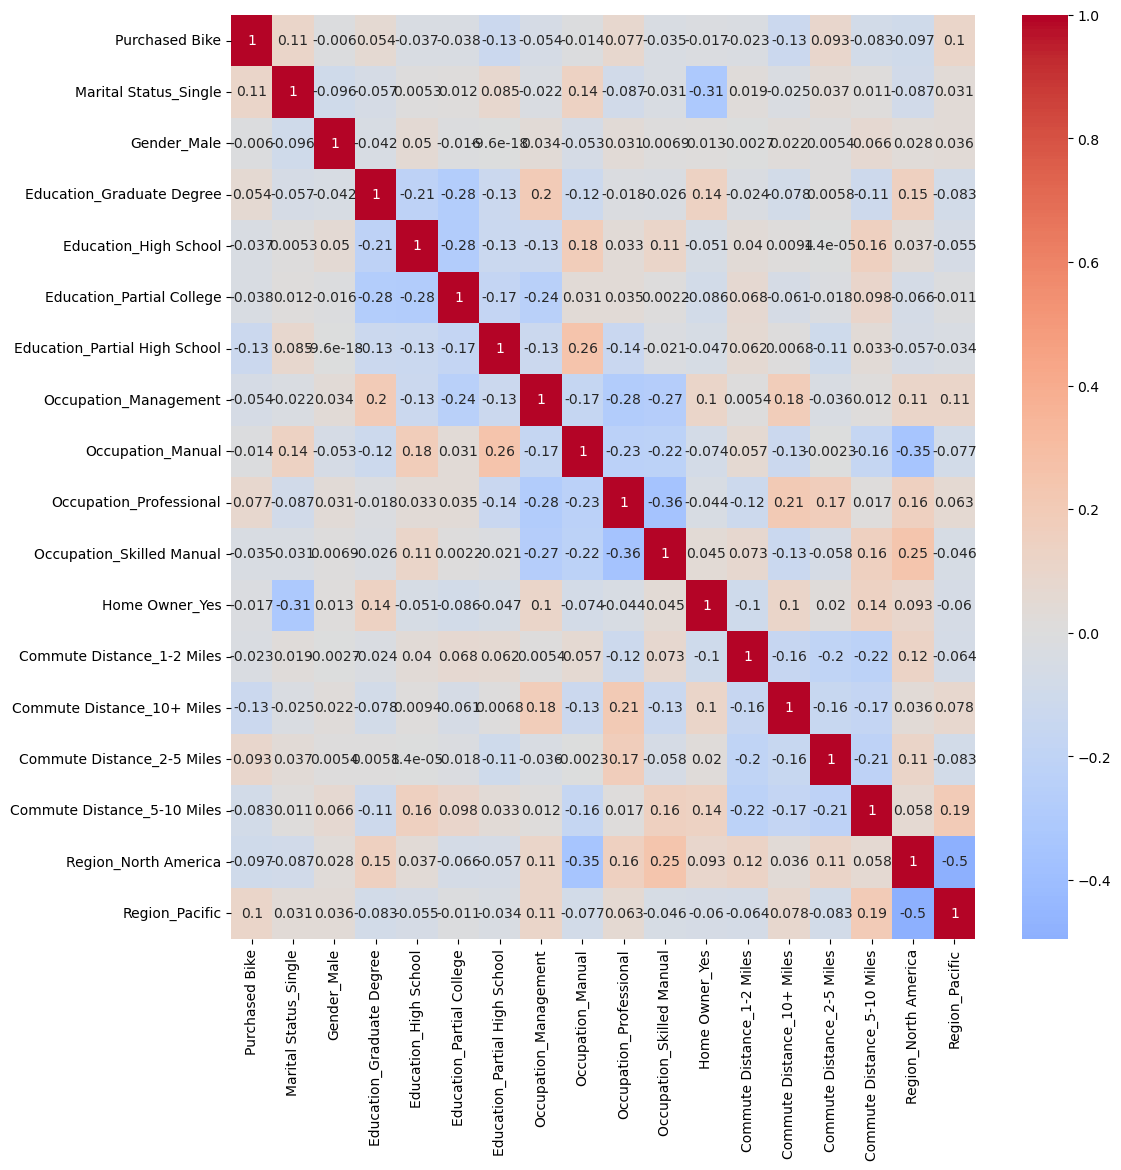

In [21]:
# transformation des valeurs catégorielles en valeurs numériques
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded = df_encoded.drop('ID', axis=1)

# suppresion valeur numérique
df_encoded = df_encoded.drop('Income', axis=1)
df_encoded = df_encoded.drop('Children', axis=1)
df_encoded = df_encoded.drop('Cars', axis=1)
df_encoded = df_encoded.drop('Age', axis=1)

print(df_encoded.describe())
plt.figure(figsize=(12, 12))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', center=0)

In [39]:
# nom des régions
print(df['Occupation'].value_counts())

# affichagage du pourcentage d'achat de vélo par région
purchase_counts = df.groupby('Occupation')['Purchased Bike'].value_counts(normalize=True).unstack()
print(purchase_counts)


Occupation
Professional      276
Skilled Manual    255
Clerical          177
Management        173
Manual            119
Name: count, dtype: int64
Purchased Bike         0         1
Occupation                        
Clerical        0.502825  0.497175
Management      0.578035  0.421965
Manual          0.537815  0.462185
Professional    0.456522  0.543478
Skilled Manual  0.549020  0.450980
